In [28]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model


In [29]:
train_df, val_df = train_test_split(
    df_suffle,
    test_size=0.2,
    random_state=42,
    stratify=df_suffle['Brand']
)


In [30]:
IMG_SIZE = 224
BATCH_SIZE = 16

train_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range=2,
    brightness_range=[0.9, 1.1]
)

val_data = ImageDataGenerator(
    rescale=1./255
)


In [31]:
train_generator = train_data.flow_from_dataframe(
    train_df,
    x_col="Image",
    y_col="Brand",
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = val_data.flow_from_dataframe(
    val_df,
    x_col="Image",
    y_col="Brand",
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    shuffle=False
)



Found 696 validated image filenames belonging to 3 classes.
Found 174 validated image filenames belonging to 3 classes.


In [32]:
base_model=MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE,IMG_SIZE,3)
)

base_model.trainable=False
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(128,activation='relu')(x)
x=Dropout(0.5)(x)
output=Dense(3,activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=output)

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [34]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)


Epoch 1/20


c:\Users\Yatendra Pachori\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 45s 792ms/step - accuracy: 0.3570 - loss: 1.2670 - val_accuracy: 0.5402 - val_loss: 0.8610
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 868ms/step - accuracy: 0.5096 - loss: 0.9768 - val_accuracy: 0.7126 - val_loss: 0.7400
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 807ms/step - accuracy: 0.5501 - loss: 0.8489 - val_accuracy: 0.6782 - val_loss: 0.6980
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 830ms/step - accuracy: 0.6260 - loss: 0.8113 - val_accuracy: 0.7471 - val_loss: 0.6630
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 777ms/step - accuracy: 0.5828 - loss: 0.8216 - val_accuracy: 0.7529 - val_loss: 0.6437
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 759ms/step - accuracy: 0.6481 - loss: 0.7062 - val_accuracy: 0.7759 - val_loss: 0.6027
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 771ms/step - accuracy: 0.6010 - loss: 0.7410 - val_accuracy: 0.7701 - val_loss: 0.6252
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 762ms/step - accuracy: 0.6861 - loss: 0.6865 - val_accuracy: 0.793

In [35]:
train_df,temp_df=train_test_split(
    df_suffle,
    test_size=0.4,         
    stratify=df_suffle['Brand'],
    random_state=42
)

val_df,test_df= train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['Brand'],
    random_state=42
)

In [36]:
test_generator=val_data.flow_from_dataframe(
    test_df,
    x_col="Image",
    y_col="Brand",
    target_size=(224,224),
    color_mode="rgb",
    batch_size=16,
    shuffle=False
)


Found 174 validated image filenames belonging to 3 classes.


In [ ]:
test_loss,test_accuracy=model.evaluate(test_generator)

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 604ms/step - accuracy: 0.8714 - loss: 0.4554


In [39]:
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
y_true=val_generator.classes
y_pred=np.argmax(model.predict(val_generator),axis=1)

print(classification_report(
    y_true,
    y_pred,
    target_names=val_generator.class_indices.keys()
))

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 671ms/step
              precision    recall  f1-score   support

       canon       0.87      0.89      0.88        70
       epson       0.85      0.67      0.75        70
          hp       0.69      0.97      0.80        34

    accuracy                           0.82       174
   macro avg       0.81      0.84      0.81       174
weighted avg       0.83      0.82      0.81       174



<Axes: >

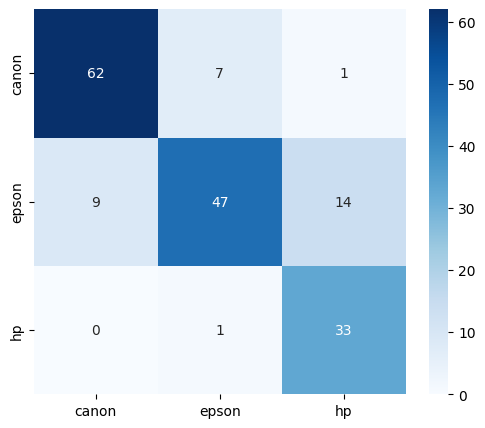

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=val_generator.class_indices.keys(),
    yticklabels=val_generator.class_indices.keys()
)


In [41]:
def grad_cam(model,image_array,last_conv1_layer_name):
    grad_model=Model([model.input],[model.get_layer(last_conv1_layer_name).output,model.output])
    
    
    with tf.GradientTape() as tap:
        conv_o, predictions = grad_model(image_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tap.gradient(loss, conv_o)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_o = conv_o[0]
    heatmap = conv_o @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()

In [42]:
image_path=val_df.iloc[0]['Image']
imag_load=tf.keras.preprocessing.image.load_img(image_path,target_size=(224,224))
image_array=tf.keras.preprocessing.image.img_to_array(imag_load)
image_array=np.expand_dims(image_array/255.0,axis=0)

heatmap=grad_cam(model,image_array,last_conv1_layer_name='Conv_1')

(-0.5, 1023.5, 1023.5, -0.5)

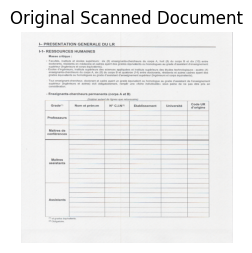

In [43]:
import cv2
original_img=cv2.imread(image_path)
original_img=cv2.cvtColor(original_img,cv2.COLOR_BGR2RGB)
original_img=cv2.resize(original_img,(1024,1024))
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.imshow(original_img)
plt.title("Original Scanned Document")
plt.axis("off")

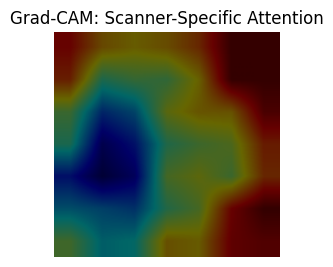

In [44]:
heatmap = cv2.resize(heatmap, (224,224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed = heatmap * 0.4 + image_array[0]


plt.subplot(1,2,2)
plt.imshow(superimposed.astype("uint8"))
plt.title("Grad-CAM: Scanner-Specific Attention")

plt.axis("off")

plt.show()
